In [62]:
!pip install gymnasium

In [63]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

### UAV Environment

In [64]:
class UAV_Environment(gym.Env):

    def __init__(self, users = 250, uavs = 3,
                 size = 2000, # Target area: size x size
                v_0 = 40, # (m/s)
                tau = 1, # (s)
                UAV_coverage = 400, # (m)
                mBS_coverage = 2000, # (m)
                ###################### Channel model of UAVS
                psi_L = 1,
                psi_M = 1,
                K = 50,
                d = 1, # (m)
                lambda_c = 0.05, # (m) = v/f = 3x10^8 (m/s)/ 5.8x10^9 (Hz) ?
                h = 400, # (m)
                alpha = 2.7,
                P_UAV = 2, # 30 (dBm) -> W
                sigma_square = 1/(1e12),  # -90 (dBm) -> W
                ###################### Channel model of mBS
                P_mBS = 50, # 76 (dBm) -> dB
                D_hb = 100, # (m) ?
                f_c = 2, # GHz ?
                sigma_logF = 2, # mean of logF ?
                ###################### Bandwidth
                W = 20e6, # Hz
                ###################### Data Rate Threshold
                r_th = 20e6, # bps
                ):


        self.users = users
        self.uavs = uavs
        self.size = size
        self.v_0 = v_0
        self.tau = tau
        self.UAV_coverage = UAV_coverage
        self.mBS_coverage = mBS_coverage

        self.psi_L = psi_L
        self.psi_M = psi_M
        self.K = K
        self.d = d
        self.lambda_c = lambda_c
        self.h = h
        self.alpha = alpha
        self.P_UAV = P_UAV
        self.sigma_square = sigma_square
        self.P_mBS = P_mBS
        self.D_hb = D_hb
        self.f_c = f_c
        self.sigma_logF = sigma_logF
        self.W = W
        self.r_th = r_th

        self.connect = np.zeros((self.uavs+1, self.users))
        self.unsatisfied_users = np.zeros(self.users)
        self.data_rate_max_index = np.zeros(self.users) - 1000

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.users_location = np.random.uniform(-self.size/2, self.size/2, (2, self.users))
        self.mBS = np.zeros((2,1)) + self.size/2

        # Each location is encoded as an element of {0, ..., `size`-1}^2
        # self.observation_space = gym.spaces.Dict(
        #     {
        #         "agent": gym.spaces.Box(-size/2, size/2, shape=(2,uavs), dtype=float),
        #     }
        # )

        self.observation_space = gym.spaces.Box(-self.size/2, self.size/2, shape=(2,uavs), dtype=float),


        # We have 5 actions, corresponding to "right", "up", "left", "down", "remain stationary"
        self.action_space = gym.spaces.Discrete(5)
        # Dictionary maps the abstract actions to the directions
        self._action_to_direction = {
            0: np.array([0, 0]),  # remain stationary
            1: np.array([0,self.v_0*self.tau]),  # up
            2: np.array([-self.v_0*self.tau, 0]),  # left
            3: np.array([0, -self.v_0*self.tau]),  # down
            4: np.array([self.v_0*self.tau, 0]),  # right
        }
    def step(self, actions):

        self.connect = np.zeros((self.uavs+1, self.users))
        self.unsatisfied_users = np.zeros(self.users)
        self.data_rate_max_index = np.zeros(self.users) - 1000

        ## UAVs take the actions
        # hit_wall = np.zeros(self.uavs)
        for (action,k) in zip(actions,range(self.uavs)):
            tem = self.uavs_location[:,k] + self._action_to_direction[action]
            if (-self.size/2 > tem[0] or tem[0] > self.size/2) or (-self.size/2 > tem[1] or tem[1] > self.size/2): # restrict the UAVs' coordinates
                # hit_wall[k] -= 0
                continue
            self.uavs_location[:,k] = tem

        ## Distance
        d_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                d_UAV[k,n] = np.linalg.norm(self.users_location[:,n] - self.uavs_location[:,k], ord = 2)

        d_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            d_mBS[0,n] = np.linalg.norm(self.users_location[:,n] - self.mBS[:,0], ord = 2)

        # connect_tem =
        # [ 0 1 0 0 1 ... 0 1]
        # [ 0 0 0 1 1 ... 0 1]
        # [ 0 0 0 1 0 ... 0 0]
        # [ 0 1 0 0 1 ... 0 1]
        connect_tem = np.zeros((self.uavs+1,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                if d_UAV[k,n] <= self.UAV_coverage:   # if < 400 (m) -> connect , may be connected to multiple UAVs
                    connect_tem[k,n] = 1

        for n in range(self.users):
            if d_mBS[0,n] <= self.mBS_coverage:    #mBS
              connect_tem[3,n] = 1


        ## Signal-to-noise ratio(SNR)
        gamma_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                psi_UAV = math.sqrt(self.K/(1+self.K))*self.psi_L + math.sqrt(1/(1+self.K))*self.psi_M
                theta = -20*math.log10(4*3.14*self.d/self.lambda_c) # (dB)
                theta = 10**(theta/10)
                g_UAV = (abs(psi_UAV)**2)*theta*(math.sqrt((d_UAV[k,n])**2 + (self.h)**2)/self.d)**(-self.alpha)
                gamma_UAV[k,n] = self.P_UAV*g_UAV/self.sigma_square

        gamma_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            # LogF = random.gauss(0, self.sigma_logF)
            L_mBS = 40*(1-0.004*self.D_hb)*math.log10(d_mBS[0,n]/1000) - 18*math.log10(self.D_hb) + 21*math.log10(self.f_c) + 80 # d_mBS (km) ; D_hb (m); fc (MHz)
            gamma_mBS[0,n] = self.P_mBS - L_mBS #- LogF  # dB

        ## Data rate
        rate_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                rate_UAV[k,n] = self.W*math.log2(1 + gamma_UAV[k,n])

        rate_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            gamma_mBS[0,n] = 10**(gamma_mBS[0,n]/10)
            rate_mBS[0,n] = self.W*math.log2(1 + gamma_mBS[0,n])


        ##### self.connect =
        #####    [ ------------ UAV1 -----------]
        #####    [ ------------ UAV2 -----------]
        #####    [ ------------ UAV3 -----------]
        #####    [ ------------ mBS  -----------]



        # print('UAV data rate: ', rate_UAV,'\n mBS data rate: ' ,rate_mBS)
        rate_UAV_mBS = np.concatenate((rate_UAV, rate_mBS), axis=0) # Shape(4,250) -> 3 UAVs + 1 mBS ; 250 Users


        # rate_UAV_mBS*connect_tem =
        # [ 0 11 0 0 31 ... 0 91]
        # [ 0 0 0 13 61 ... 0 11]
        # [ 0 0 0 17 0 ...  0  0]
        # [ 0 12 0 0 13 ... 0 11]
        rate_UAV_mBS = np.multiply(rate_UAV_mBS, connect_tem)

        # data_rate_max_index - [0 2 1 3 ... 1 1 0]
        self.data_rate_max_index = np.argmax(rate_UAV_mBS, axis=0) # UAV0 = 0, UAV1 = 1, UAV2 = 2, mBS = 3
        for (index,user) in zip(self.data_rate_max_index,range(self.users)):
            # print('print = ', index, user)
            # if not connect any UAVs/mBS -> max index = -1000
            if connect_tem[0,user] == connect_tem[1,user] == connect_tem[2,user] == connect_tem[3,user] == 0:
                self.data_rate_max_index[user] = -1000
                continue

            self.connect[index,user] = 1



        data_rate = np.multiply(rate_UAV_mBS,self.connect)
        data_rate = np.sum(data_rate,axis=0)

        for i in range(data_rate.shape[0]):
            if data_rate[i] < self.r_th:
                self.unsatisfied_users[i] = 0 # -> unsatisfied user
            else:
                self.unsatisfied_users[i] = 1 # -> satisfied user

        # S (sum of satisfied users)
        S = np.sum(self.unsatisfied_users)

        N_UAVs = np.sum(self.connect, axis=1)
        N_UAV0 = N_UAVs[0]
        # print('N_UAV0=',N_UAV0)
        N_UAV1 = N_UAVs[1]
        # print('N_UAV1=',N_UAV1)
        N_UAV2 = N_UAVs[2]
        # print('N_UAV2=',N_UAV2)

        UAV0_users_location = np.multiply(self.users_location, self.connect[0,:])
        UAV1_users_location = np.multiply(self.users_location, self.connect[1,:])
        UAV2_users_location = np.multiply(self.users_location, self.connect[2,:])

        satisfied_users = np.multiply(self.users_location, self.unsatisfied_users)

        O_UAV0 = np.concatenate((self.uavs_location[:,0], self.mBS[:,0],self.uavs_location[:,1],self.uavs_location[:,2],np.reshape(UAV0_users_location.T,500)))
        # print('O_UAV0=',O_UAV0.shape)
        O_UAV1 = np.concatenate((self.uavs_location[:,1], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,2],np.reshape(UAV1_users_location.T,500)))
        # print('O_UAV1=',O_UAV1.shape)
        O_UAV2 = np.concatenate((self.uavs_location[:,2], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,1],np.reshape(UAV2_users_location.T,500))) # np.reshape(satisfied_users.T,500)
        # print('O_UAV2=',O_UAV2.shape)


        return O_UAV0, O_UAV1, O_UAV2, S, N_UAV0, N_UAV1, N_UAV2

    def plot(self):
        # plt.scatter(self.users_location[0,:],self.users_location[1,:], marker = 'o', color = 'c')
        plt.scatter(self.uavs_location[0,0],self.uavs_location[1,0], label = 'UAV0', marker = ',', color = 'r')
        plt.scatter(self.uavs_location[0,1],self.uavs_location[1,1], label = 'UAV1', marker = ',', color = 'g')
        plt.scatter(self.uavs_location[0,2],self.uavs_location[1,2], label = 'UAV2', marker = ',', color = 'b')
        plt.scatter(self.mBS[0],self.mBS[1], label = 'mBS', marker = ',', color = 'm')
        # print(self.data_rate_max_index)
        # print(self.unsatisfied_users)
        for i in range(self.unsatisfied_users.shape[0]):
            # UAV0
            if self.data_rate_max_index[i] == 0 and self.unsatisfied_users[i] == 0:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = '^', color = 'r')
            elif self.data_rate_max_index[i] == 0 and self.unsatisfied_users[i] == 1:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = 'o', color = 'r')

            # UAV1
            if self.data_rate_max_index[i] == 1 and self.unsatisfied_users[i] == 0:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = '^', color = 'g')
            elif self.data_rate_max_index[i] == 1 and self.unsatisfied_users[i] == 1:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = 'o', color = 'g')

            # UAV2
            if self.data_rate_max_index[i] == 2 and self.unsatisfied_users[i] == 0:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = '^', color = 'b')
            elif self.data_rate_max_index[i] == 2 and self.unsatisfied_users[i] == 1:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = 'o', color = 'b')

            # mBS
            if self.data_rate_max_index[i] == 3 and self.unsatisfied_users[i] == 0:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = '^', color = 'm')
            elif self.data_rate_max_index[i] == 3 and self.unsatisfied_users[i] == 1:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = 'o', color = 'm')

            # not connected
            if self.data_rate_max_index[i] == -1000:
                plt.scatter(self.users_location[0,i],self.users_location[1,i], marker = 'x', color = 'gray')

        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.title('UAV Environment')
        plt.legend()
        plt.show()

    def reset(self):
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.connect = np.zeros((self.uavs+1, self.users))
        self.unsatisfied_users = np.zeros(self.users)

        UAV0_users_location = np.multiply(self.users_location, self.connect[0,:])
        UAV1_users_location = np.multiply(self.users_location, self.connect[1,:])
        UAV2_users_location = np.multiply(self.users_location, self.connect[2,:])

        satisfied_users = np.multiply(self.users_location, self.unsatisfied_users)

        O_UAV0 = np.concatenate((self.uavs_location[:,0], self.mBS[:,0],self.uavs_location[:,1],self.uavs_location[:,2],np.reshape(UAV0_users_location.T,500)))
        # print('O_UAV0=',O_UAV0.shape)
        O_UAV1 = np.concatenate((self.uavs_location[:,1], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,2],np.reshape(UAV1_users_location.T,500)))
        # print('O_UAV1=',O_UAV1.shape)
        O_UAV2 = np.concatenate((self.uavs_location[:,2], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,1],np.reshape(UAV2_users_location.T,500)))
        # print('O_UAV2=',O_UAV2.shape)

        return O_UAV0, O_UAV1, O_UAV2


In [65]:
env = UAV_Environment()

Start Environment

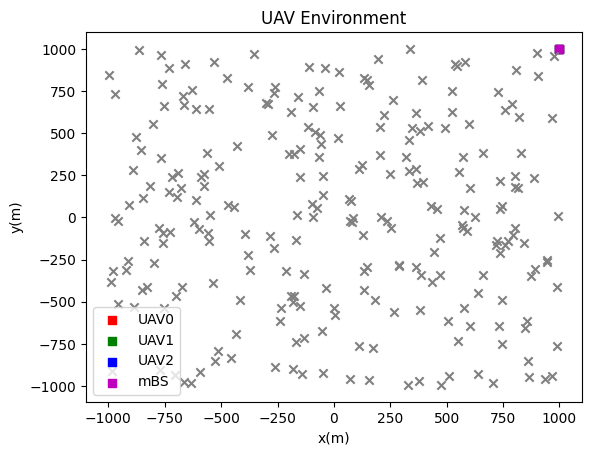

In [66]:
env.plot()

In [67]:
# state = env.reset()
# for _ in range(100):
#     actions = []
#     for i in range(4):
#         actions.append(env.action_space.sample())
#     O_UAV0, O_UAV1, O_UAV2, S, N_UAV0, N_UAV1, N_UAV2 = env.step(actions)

In [68]:
# env.plot()

### Multi-agent Deep Reinforcement Learning

In [69]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [71]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.99
epsilon = 0.1
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 1000

In [72]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [73]:
policy_net0 = DQN(508, 5).to(device)
target_net0 = DQN(508, 5)

policy_net1 = DQN(508, 5).to(device)
target_net1 = DQN(508, 5)

policy_net2 = DQN(508, 5).to(device)
target_net2 = DQN(508, 5)

# optimizer = optim.Adam(list(policy0.parameters()) + list(policy1.parameters()) + list(policy2.parameters()), lr = lr )

In [74]:
optimizer0 = optim.Adam(policy_net0.parameters(), lr=learning_rate)
optimizer1 = optim.Adam(policy_net1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(policy_net2.parameters(), lr=learning_rate)

memory0 = deque(maxlen=memory_size)
memory1 = deque(maxlen=memory_size)
memory2 = deque(maxlen=memory_size)

Episode  0 : The percentage of satisfied users =  17.2 %


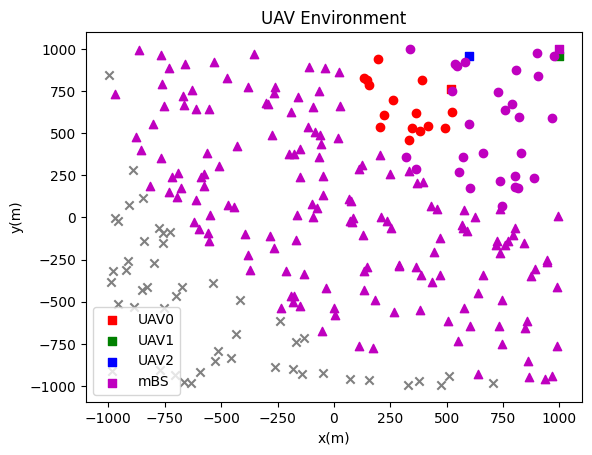

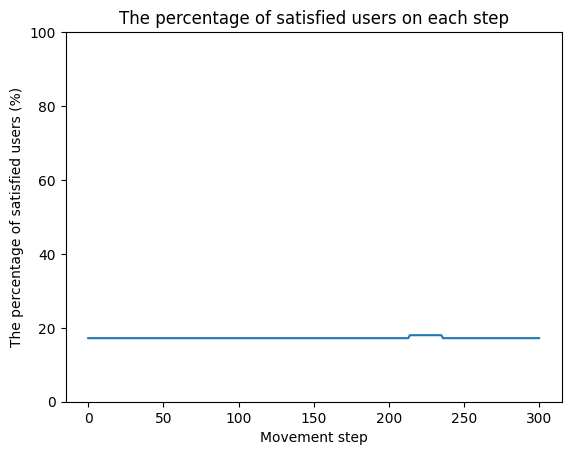

Episode  1 : The percentage of satisfied users =  32.0 %


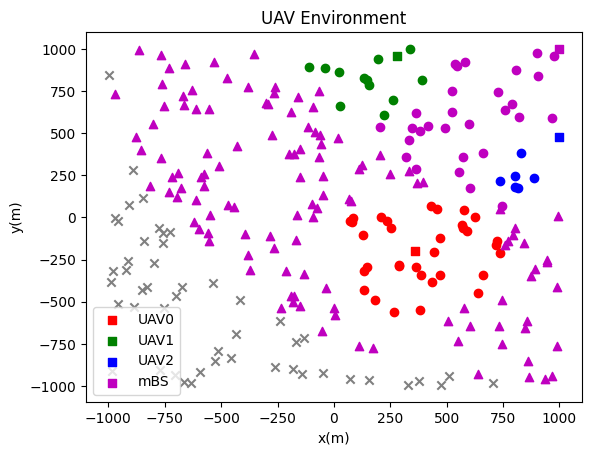

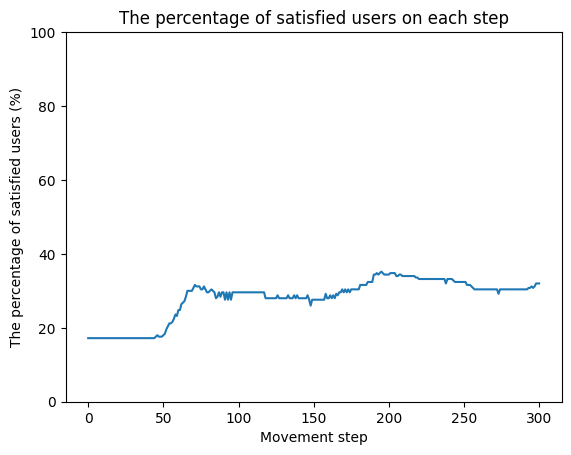

Episode  2 : The percentage of satisfied users =  38.0 %


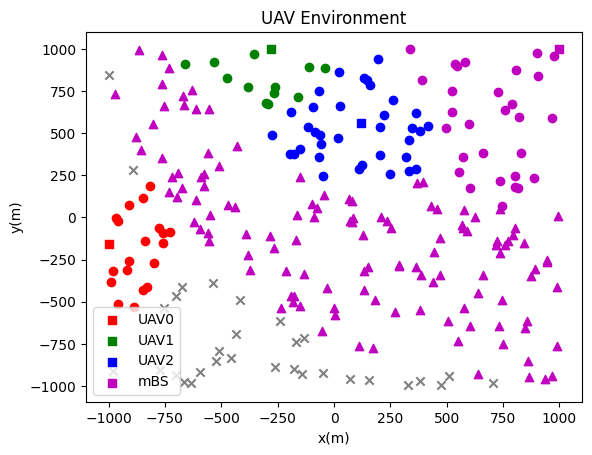

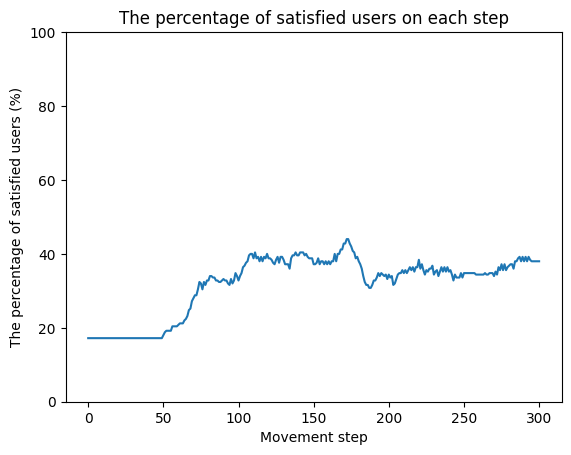

Episode  3 : The percentage of satisfied users =  33.6 %


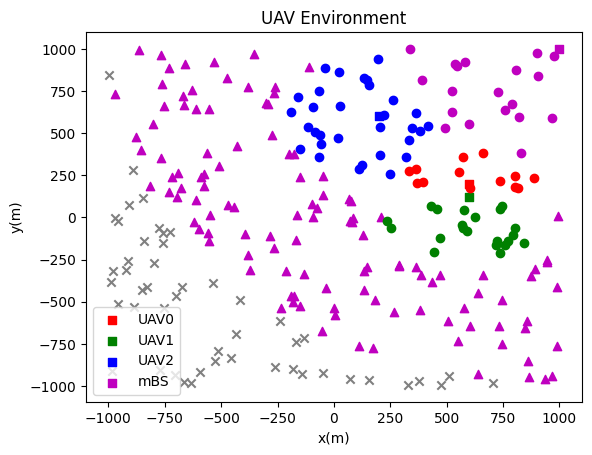

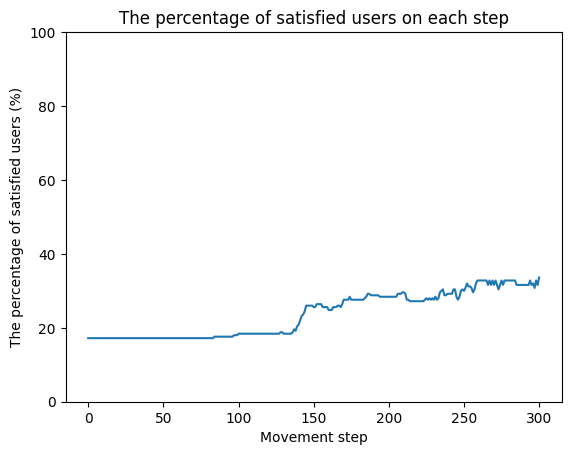

Episode  4 : The percentage of satisfied users =  29.6 %


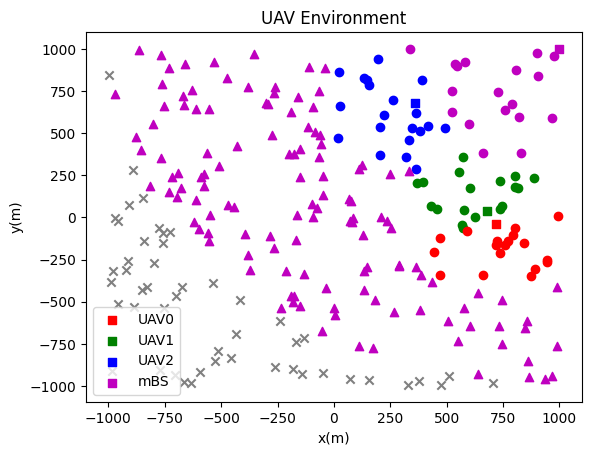

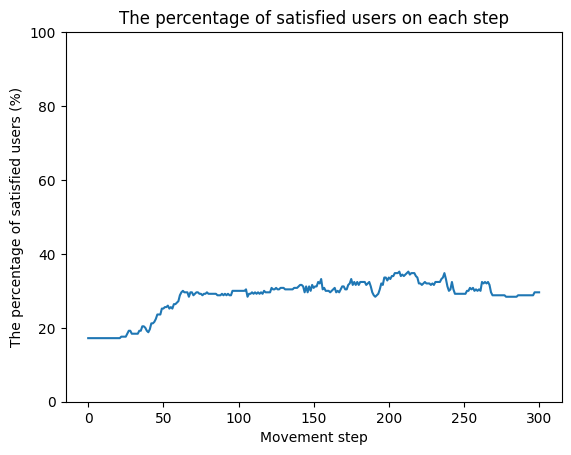

Episode  5 : The percentage of satisfied users =  44.8 %


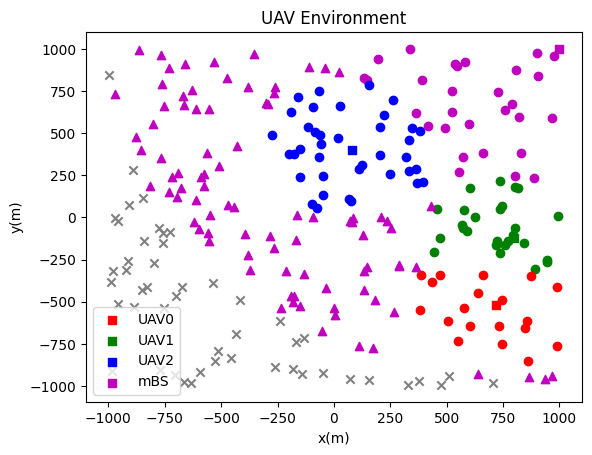

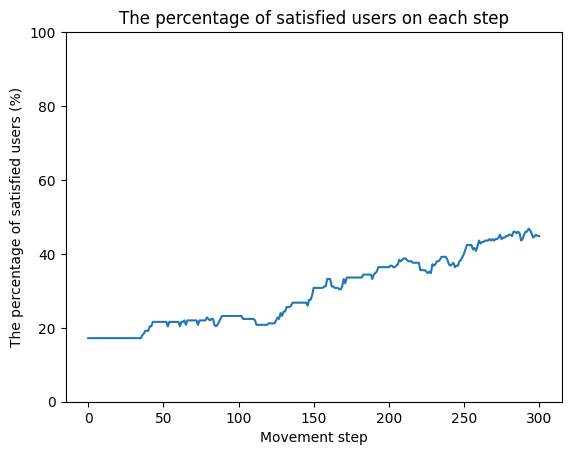

Episode  6 : The percentage of satisfied users =  32.0 %


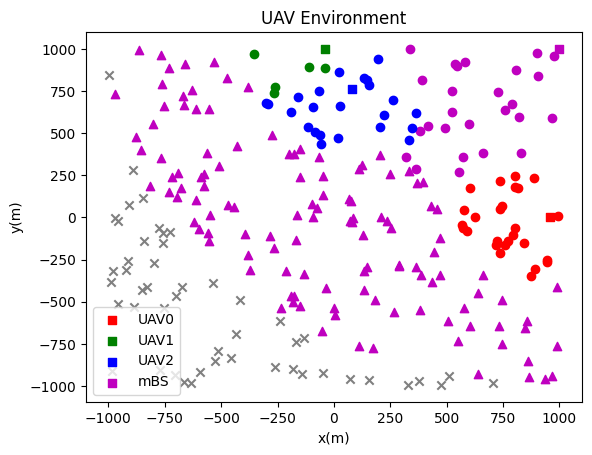

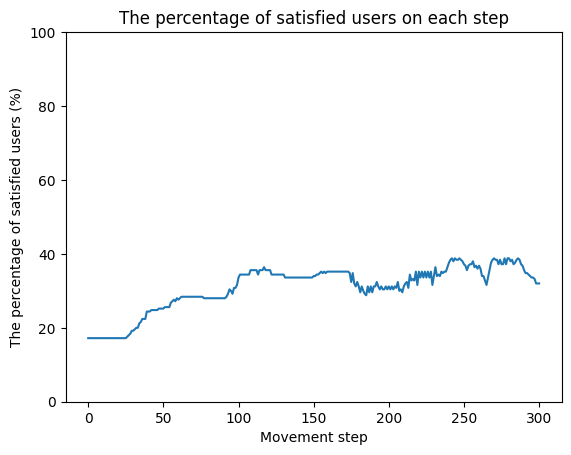

Episode  7 : The percentage of satisfied users =  28.8 %


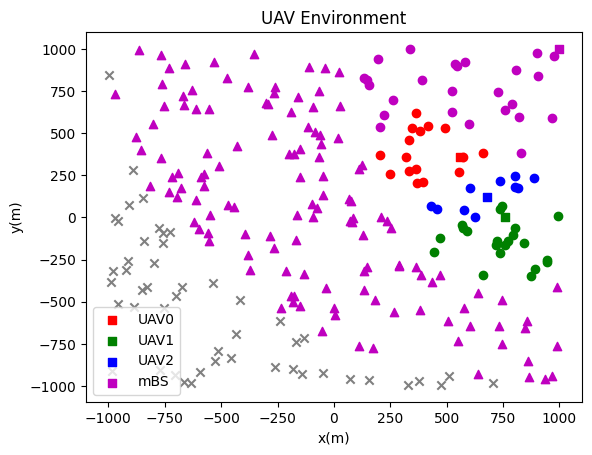

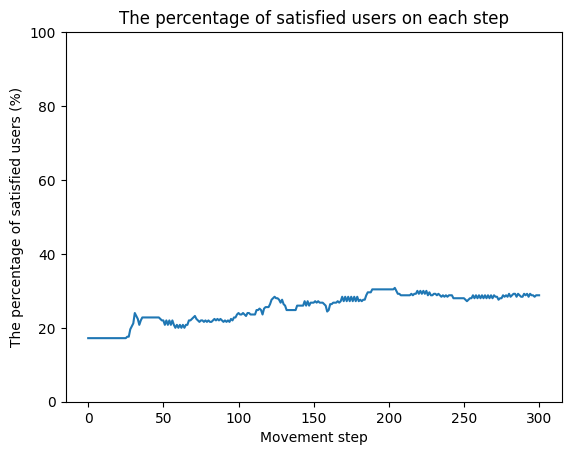

Episode  8 : The percentage of satisfied users =  41.6 %


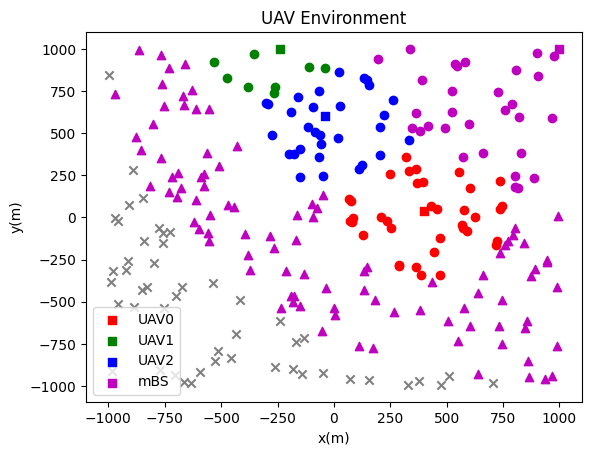

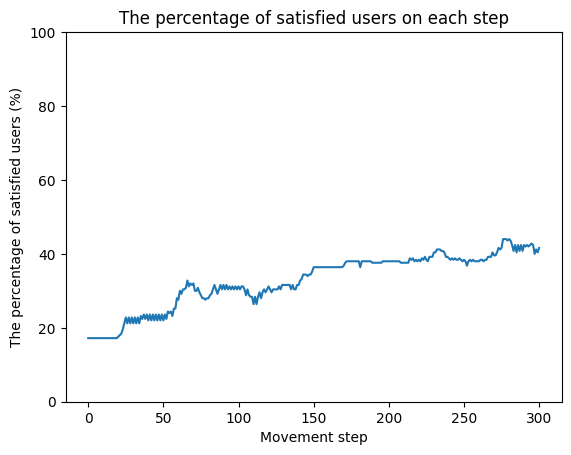

KeyboardInterrupt: 

In [75]:
# Function to choose action using epsilon-greedy policy
def select_action(state, policy_net, epsilon):
    rand_value = random.random()
    if rand_value < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state.to(device))
        return torch.argmax(q_values).item()  # Exploit

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory0) < batch_size:
        return
    if len(memory1) < batch_size:
        return
    if len(memory2) < batch_size:
        return

    batch0 = random.sample(memory0, batch_size)
    UAV0_batch, action0_batch, reward0_batch, next_UAV0_batch = zip(*batch0)

    batch1 = random.sample(memory1, batch_size)
    UAV1_batch, action1_batch, reward1_batch, next_UAV1_batch = zip(*batch1)

    batch2 = random.sample(memory2, batch_size)
    UAV2_batch, action2_batch, reward2_batch, next_UAV2_batch = zip(*batch2)

    UAV0_batch = torch.FloatTensor(UAV0_batch)
    action0_batch = torch.LongTensor(action0_batch).unsqueeze(1)
    reward0_batch = torch.FloatTensor(reward0_batch)
    next_UAV0_batch = torch.FloatTensor(next_UAV0_batch)

    UAV1_batch = torch.FloatTensor(UAV1_batch)
    action1_batch = torch.LongTensor(action1_batch).unsqueeze(1)
    reward1_batch = torch.FloatTensor(reward1_batch)
    next_UAV1_batch = torch.FloatTensor(next_UAV1_batch)

    UAV2_batch = torch.FloatTensor(UAV2_batch)
    action2_batch = torch.LongTensor(action2_batch).unsqueeze(1)
    reward2_batch = torch.FloatTensor(reward2_batch)
    next_UAV2_batch = torch.FloatTensor(next_UAV2_batch)



    # Compute Q-values for current states
    q_values0 = policy_net0(UAV0_batch.to(device)).gather(1, action0_batch.to(device)).squeeze()
    q_values1 = policy_net1(UAV1_batch.to(device)).gather(1, action1_batch.to(device)).squeeze()
    q_values2 = policy_net2(UAV2_batch.to(device)).gather(1, action2_batch.to(device)).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values0 = target_net0(next_UAV0_batch).max(1)[0]
        target_q_values0 = reward0_batch + gamma * max_next_q_values0

        max_next_q_values1 = target_net1(next_UAV1_batch).max(1)[0]
        target_q_values1 = reward1_batch + gamma * max_next_q_values1

        max_next_q_values2 = target_net2(next_UAV2_batch).max(1)[0]
        target_q_values2 = reward2_batch + gamma * max_next_q_values2

    loss0 = nn.MSELoss()(q_values0, target_q_values0.to(device))
    loss1 = nn.MSELoss()(q_values1, target_q_values1.to(device))
    loss2 = nn.MSELoss()(q_values2, target_q_values2.to(device))


    optimizer0.zero_grad()
    loss0.backward()
    optimizer0.step()

    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

# Main training loop
rewards_per_episode = []
steps_done = 0
done = False


for episode in range(episodes):
    O_UAV0, O_UAV1, O_UAV2 = env.reset()
    # episode_reward0 = 0
    # episode_reward1 = 0
    # episode_reward2 = 0
    S_t, N_UAV0_t, N_UAV1_t, N_UAV2_t = 0,0,0,0
    g_t = 0
    l_t_0 = 0
    l_t_1 = 0
    l_t_2 = 0
    w = 0.8
    percentage_users = []



    # the maximum step of one episode
    count = 0

    # One episode (One Trajectory)
    while not done:

        if count > 300:
          break

        # Select action
        action0 = select_action(O_UAV0, policy_net0, epsilon)
        action1 = select_action(O_UAV1, policy_net1, epsilon)
        action2 = select_action(O_UAV2, policy_net2, epsilon)
        next_O_UAV0, next_O_UAV1, next_O_UAV2, S, N_UAV0, N_UAV1, N_UAV2 = env.step([action0, action1, action2])

        if S > S_t:
            g_t = 1
        elif S < S_t:
            g_t = -1
        else:
            g_t = 0

        if N_UAV0 > N_UAV0_t:
            l_t_0 = 1
        elif N_UAV0 < N_UAV0_t:
            l_t_0 = -1
        else:
            l_t_0 = 0

        if N_UAV1 > N_UAV1_t:
            l_t_1 = 1
        elif N_UAV1 < N_UAV1_t:
            l_t_1 = -1
        else:
            l_t_1 = 0

        if N_UAV2 > N_UAV2_t:
            l_t_2 = 1
        elif N_UAV2 < N_UAV2_t:
            l_t_2 = -1
        else:
            l_t_2 = 0

        S_t, N_UAV0_t, N_UAV1_t, N_UAV2_t = S, N_UAV0, N_UAV1, N_UAV2

        # print(S_t, N_UAV0_t, N_UAV1_t, N_UAV2_t)

        reward0 = w*l_t_0 + (1-w)*g_t
        reward1 = w*l_t_1 + (1-w)*g_t
        reward2 = w*l_t_2 + (1-w)*g_t

        # Store transition in memory
        memory0.append((O_UAV0, action0, reward0, next_O_UAV0))
        memory1.append((O_UAV1, action1, reward1, next_O_UAV1))
        memory2.append((O_UAV2, action2, reward2, next_O_UAV2))


        # Update state
        O_UAV0, O_UAV1, O_UAV2 = next_O_UAV0, next_O_UAV1, next_O_UAV2
        # episode_reward += reward

        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net0.load_state_dict(policy_net0.state_dict())
            target_net1.load_state_dict(policy_net1.state_dict())
            target_net2.load_state_dict(policy_net2.state_dict())

        steps_done += 1
        count += 1

        percentage_users.append(S_t*100/250)

    # Decay epsilon
    print('Episode ',episode,': The percentage of satisfied users = ', S_t*100/250 , '%')
    env.plot()

    plt.plot(percentage_users)
    plt.ylim(0, 100)
    plt.xlabel('Movement step')
    plt.ylabel('The percentage of satisfied users (%)')
    plt.title('The percentage of satisfied users on each step')
    plt.show()

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    # rewards_per_episode.append(episode_reward)

Triangle -> Unsatisfied user <br>
Circle -> Satisfied user <br>
----------------------------- <br>
X-shaped -> Unconnected user